In [1]:
from Crypto.Util.number import *
from Crypto.Hash import BLAKE2b
import math

In [2]:
def xor(ba1, ba2): # OK (?)
    return (int.from_bytes(ba1, 'little') ^ int.from_bytes(ba2, 'little')).to_bytes(max(len(ba1), len(ba2)), 'little')

def print_LE_hex(bs):
    print("".join(reversed([bs[2*i:2*i+2] for i in range(0, len(bs)//2)])))

def print_32byte_hex_block(block, number='xxxx'):
    number = str(number)
    for i in range(len(block)//16):
        if number != 'xxxx':
            print(f"Block {number:0>4} [{i:>3}]:", end=' ')
        else:
            print(f"Block xxxx:", end=' ')
        print_LE_hex(block[16 * i:16 * (i+1)])

In [3]:
# RFC H' function
def Hash(message: bytes, outSize: int):
    if outSize <= 64:
        return bytes.fromhex(BLAKE2b.new(data=(outSize.to_bytes(4, "little") + message),
                                         digest_bytes=outSize).hexdigest())
    r = math.ceil(outSize/32) - 2
    
    Vs = [bytes.fromhex(BLAKE2b.new(data=(outSize.to_bytes(4, "little") + message),
                                    digest_bytes=64).hexdigest())]
    for i in range(r-1):
        Vs.append(bytes.fromhex(BLAKE2b.new(data=(Vs[-1]),
                                            digest_bytes=64).hexdigest()))
    
    bytesNeeded = outSize - 32 * r
    Vs.append(bytes.fromhex(BLAKE2b.new(data=(Vs[-1]),
                                        digest_bytes=bytesNeeded).hexdigest()))
    
    result = bytes()
    for i in range(len(Vs) - 1):
        result += Vs[i][:32]
    result += Vs[-1]
    return result

In [4]:
# Permutation P as defined in RFC
def P(*Ss):
    Ss = list(Ss)
    vs = [None] * 16
    for i in range(8):
        vs[2*i], vs[2*i+1] = int.from_bytes(Ss[i][:8], "little"), int.from_bytes(Ss[i][8:16], "little")
    vs[0], vs[4], vs[8], vs[12] = GB(vs[0], vs[4], vs[8], vs[12])
    vs[1], vs[5], vs[9], vs[13] = GB(vs[1], vs[5], vs[9], vs[13])
    vs[2], vs[6], vs[10], vs[14] = GB(vs[2], vs[6], vs[10], vs[14])
    vs[3], vs[7], vs[11], vs[15] = GB(vs[3], vs[7], vs[11], vs[15])
    vs[0], vs[5], vs[10], vs[15] = GB(vs[0], vs[5], vs[10], vs[15])
    vs[1], vs[6], vs[11], vs[12] = GB(vs[1], vs[6], vs[11], vs[12])
    vs[2], vs[7], vs[8], vs[13] = GB(vs[2], vs[7], vs[8], vs[13])
    vs[3], vs[4], vs[9], vs[14] = GB(vs[3], vs[4], vs[9], vs[14])
    for i in range(len(Ss)):
        Ss[i] = vs[2*i].to_bytes(8, 'little') + vs[2*i+1].to_bytes(8, 'little')
    return Ss

# rotate 64-bit number by n bits to the right
def rotate(x: int, n: int): # 64-bit - works
    return ((x >> n) | (x << (64 - n))) & ((1 << 64) - 1)

def GB(a, b, c, d):
    ones_64 = (1 << 64) - 1
    a = (a + b + 2 * (a & 0xffffffff) * (b & 0xffffffff)) & ones_64
    d = rotate(d ^ a, 32)
    c = (c + d + 2 * (c & 0xffffffff) * (d & 0xffffffff)) & ones_64
    b = rotate(b ^ c, 24)
    
    a = (a + b + 2 * (a & 0xffffffff) * (b & 0xffffffff)) & ones_64
    d = rotate(d ^ a, 16)
    c = (c + d + 2 * (c & 0xffffffff) * (d & 0xffffffff)) & ones_64
    b = rotate(b ^ c, 63)
    

    return a, b, c, d

In [5]:
def G(X: bytes, Y: bytes):
    R = xor(X, Y)
    Q = []
    for i in range(0, 64, 8):
        new = P(R[i*16 : (i+1)*16],
                R[(i+1)*16 : (i+2)*16],
                R[(i+2)*16 : (i+3)*16],
                R[(i+3)*16 : (i+4)*16],
                R[(i+4)*16 : (i+5)*16],
                R[(i+5)*16 : (i+6)*16],
                R[(i+6)*16 : (i+7)*16],
                R[(i+7)*16 : (i+8)*16]
               )
        for q in new:
            Q.append(q)
    Z = [None] * 64
    for i in range(8):
        Z_row = P(Q[i], Q[i+8], Q[i+16], Q[i+24], Q[i+32], Q[i+40], Q[i+48], Q[i+56])
        for j, element in enumerate(Z_row):
            Z[i + 8*j] = element
    finalBlock = b''.join(Z)
    return xor(finalBlock, R)

In [6]:
def log(B, very_verbose):
    if very_verbose:
        for i in range(len(B)):
            for j in range(len(B[i])):
                print_32byte_hex_block(B[i][j].hex(), i*len(B[0])+j)
    else:
        print("Block 0000 [  1]:", end=' ')
        print_LE_hex(B[0][0].hex()[:16])
        print("Last block [127]:", end=' ')
        print_LE_hex(B[-1][-1].hex()[-16:])

def argon2(password: bytes, salt: bytes, threads: int, outLen: int,
           memorySize: int, iterations: int, version=0x13, key=bytes(), data=bytes(), hashType=0, debug=False,
          very_verbose=False):
    # RFC9106 names to arg names
    # P - password (message string)
    # S - salt
    # p - threads
    # T (Tag length) - outLen
    # m - memorySize
    # t - iterations
    # v - version
    # K (secret value) - key
    # X (associated data) - data
    # y - hashType (Argon2d/Argon2i/Argon2id) - only Argon2d implemented
    
    # an attempt to convert RFC docs to code
    def GetBlockIndexes(i, j, iteration):
        if j > 0 or iteration > 1:
            J1, J2 = int.from_bytes(B[i][j-1][:4], "little"), int.from_bytes(B[i][j-1][4:8], "little")
            l = J2 % threads

        # compiling https://orbilu.uni.lu/bitstream/10993/31652/1/Argon2ESP.pdf (doc 1)
        # and https://www.rfc-editor.org/rfc/rfc9106.html#name-deriving-j1j2-in-argon2d (doc 2)
        # together I think it'll be something like this
        current_slice = j // (columnCount // 4)
        if current_slice == 0 and iteration == 1:
            l = i

        slice_length = columnCount // 4
        if iteration > 1:
            if l == i or current_slice == 0: # same lane
                W_size = columnCount - slice_length + j - current_slice * slice_length - 1
            elif j == slice_length * current_slice: # first block in segment
                W_size = columnCount - slice_length - 1
            else: # other lane
                W_size = columnCount - slice_length
        else:
            if current_slice == 0: # first slice, first iteration
                W_size = j - 1
            elif j == slice_length * current_slice: # first block in not first slice
                W_size = current_slice * slice_length - 1
            else:
                W_size = current_slice * slice_length

        # now with W_size calculation complete, we can get the block indices:
        # according to RFC:
        x = (J1 ** 2) >> 32
        y = (W_size * x) >> 32
        zz = W_size - 1 - y
        
        z = slice_length * (current_slice+1) if iteration > 1 and current_slice != 3 else 0
        z = (z + zz) % columnCount
        return l, z
            
    if memorySize < 8 * threads:
        raise Exception("MemorySize arg must be greater than 4*threads")
    if iterations < 1:
        raise Exception("Iterations count must be positive")
        

    buffer = threads.to_bytes(4, "little") + outLen.to_bytes(4, "little") + memorySize.to_bytes(4, "little") + \
        iterations.to_bytes(4, "little") + version.to_bytes(4, "little") + hashType.to_bytes(4, "little") + \
        len(password).to_bytes(4, "little") + password + \
        len(salt).to_bytes(4, "little") + salt + \
        len(key).to_bytes(4, "little") + key + \
        len(data).to_bytes(4, "little") + data

    H0 = bytes.fromhex(BLAKE2b.new(data=buffer, digest_bytes=64).hexdigest())
    
    if debug:
        print("Initial digest", H0.hex())
    
    blockCount = 4 * threads * (memorySize // (4*threads))

    columnCount = blockCount // threads
    
    B = [[None for _ in range(columnCount)] for _ in range(threads)]
    for i in range(threads):
        zero, one = 0, 1
        B[i][0] = Hash(H0 + zero.to_bytes(4, "little") + i.to_bytes(4, "little"), 1024)
        B[i][1] = Hash(H0 + one.to_bytes(4, "little") + i.to_bytes(4, "little"), 1024)
        
    
    for j in range(2, columnCount):
        for i in range(threads):
            i2, j2 = GetBlockIndexes(i, j, 1)
            B[i][j] = G(B[i][j-1], B[i2][j2])

    if debug:
        print("After pass 1:")
        log(B, very_verbose)
                    
    
    for nIter in range(2, iterations+1):
        for j in range(columnCount):
            for i in range(threads):
                if j == 0:
                    i2, j2 = GetBlockIndexes(i, j, nIter)
                    B[i][0] = xor(B[i][0], G(B[i][columnCount-1], B[i2][j2]))
                else:
                    i2, j2 = GetBlockIndexes(i, j, nIter)
                    B[i][j] = xor(B[i][j], G(B[i][j-1], B[i2][j2]))
        if debug:
            print(f"After pass {nIter}:")
            log(B, very_verbose)

    C = B[0][columnCount-1]
    for i in range(1, threads):
        C = xor(C, B[i][columnCount-1])
    
    return Hash(C, outLen)

In [7]:
# test vector from RFC specification
memorySize = 32 # KiB
iterations = 3
threads = 4
outLen = 32 # bytes
password = long_to_bytes(1) * 32
salt = long_to_bytes(2) * 16
secret = long_to_bytes(3) * 8
data = long_to_bytes(4) * 12
firstBlockFirstPart = "db2fea6b2c6f5c8a"
lastBlockFirstPart = "28d17914aea9734c"
correctHashStart = "512b391b6f116297"

In [8]:
argon2(password, salt, threads, outLen, memorySize, iterations, key=secret, data=data, debug=True).hex()

Initial digest b8819791a0359660bb7709c85fa48f04d5d82c05c5f215ccdb885491717cf757082c28b951be381410b5fc2eb7274033b9fdc7ae672bcaac5d179097a4af3109
After pass 1:
Block 0000 [  1]: db2fea6b2c6f5c8a
Last block [127]: 6a6c49d2cb75d5b6
After pass 2:
Block 0000 [  1]: d3801200410f8c0d
Last block [127]: 2dbfff23f31b5883
After pass 3:
Block 0000 [  1]: 5f047b575c5ff4d2
Last block [127]: c341b3ca45c10da5


'512b391b6f1162975371d30919734294f868e3be3984f3c1a13a4db9fabe4acb'

In [9]:
import time
def measure_execution_time(func, *func_args, **func_kwargs):
    start = time.time()
    func(*func_args, **func_kwargs)
    return time.time() - start

In [10]:
kwargs = {
    "password": password,
    "salt": salt,
    "threads": threads,
    "outLen": outLen,
    "memorySize": memorySize,
    "iterations": iterations,
    "key": secret,
    "data": data,
    "debug": False}

In [11]:
import matplotlib.pyplot as plt

def plot_times(func, func_kwargs, changing_param, param_range: list, title=""):
    func_kwargs = func_kwargs.copy()
    times = []
    for p in param_range:
        func_kwargs[changing_param] = p
        times.append(measure_execution_time(func, **func_kwargs))
    fig, ax = plt.subplots()
    ax.scatter(param_range, times)
    ax.set_xlabel(changing_param)
    ax.set_ylabel("Time to calculate [s]")
    plt.show()

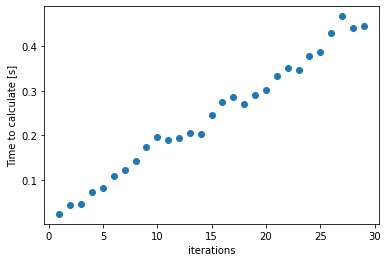

In [12]:
plot_times(argon2, kwargs, "iterations", list(range(1, 30)))

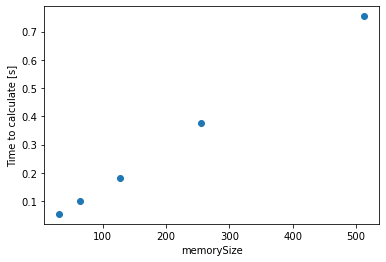

In [13]:
plot_times(argon2, kwargs, "memorySize", [2 ** i for i in range(5, 10)])

In [14]:
from itertools import product as prod
def crack_argon(digest, params, log=False):
    if log:
        print(params)
    alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&*()"
    length = 0
    while True:
        passwords = prod(alphabet, repeat=length)
        for password in passwords:
            password = bytes("".join(password), encoding='ascii')
            params["password"] = password
            if argon2(**params).hex() == digest:
                print("Password:", password.decode('ascii'))
                return password
        length += 1
        if log:
            print(f"Checking length {length}")

Password: a
Password: a
Password: 1
Password: 1
Password: ab
Password: ab
Password: 12
Password: 12
Password: abc
Password: abc


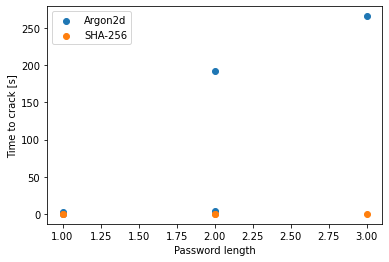

In [15]:
import hashlib


def crack_sha256(digest, log=False):
    alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&*()"
    length = 0
    while True:
        passwords = prod(alphabet, repeat=length)
        for password in passwords:
            p = bytes("".join(password), encoding='ascii')
            h = hashlib.sha256(p)
            if h.hexdigest() == digest:
                print("Password:", p.decode('ascii'))
                return password
        length += 1
        if log:
            print(f"Checking length {length}")
    
kwargs["threads"] = 1
kwargs["iterations"] = 3
times_argon = []
times_sha = []
passwords = ["a", "1", "ab", "12", "abc"]
for p in passwords:
    kwargs["password"] = p.encode('ascii')
    digest_argon = argon2(**kwargs).hex()
    digest_sha = hashlib.sha256(p.encode('ascii')).hexdigest()
    times_argon.append(measure_execution_time(crack_argon, digest_argon, kwargs))
    times_sha.append(measure_execution_time(crack_sha256, digest_sha))

fig, ax = plt.subplots()
ax.scatter([1, 1, 2, 2, 3], times_argon, label='Argon2d')
ax.scatter([1, 1, 2, 2, 3], times_sha, label='SHA-256')
ax.set_xlabel("Password length")
ax.set_ylabel("Time to crack [s]")
ax.legend()
plt.show()